In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

print(proj_root)

d:\Work\repos\RL\phd-rl-algos


In [3]:
import numpy as np
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from dqn.opinion_dynamics.utils.experiment import build_environment

from dynamic_programming.opinion_dynamics.algos import compute_average_error, compute_final_average_error, generate_full_control_policy, generate_control_from_vector
from dynamic_programming.opinion_dynamics.algo_infinite_horizon import value_iteration, extract_policy, create_state_grid
from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env


In [4]:

def run_policy(env, policy, nx, step_duration, max_steps=1000):
    """
    Run the simulation using a given policy with a maximum number of steps.

    Args:
        env: The environment with network properties.
        policy: The control policy to be used.
        nx: Number of grid points per dimension (used for mapping states to grid indices).
        step_duration: Duration of each policy application.
        tolerance: Tolerance for the mean opinion to stop the simulation.
        max_steps: Maximum number of steps to run.

    Returns:
        opinions_over_time: Array of opinions over the entire simulation.
        time_points: Corresponding time points for each opinion snapshot.
        rewards_over_time: Collected rewards at each step.
    """
    N = env.num_agents
    time_points = []
    rewards_over_time = []
    current_time = 0.0
    state, _ = env.reset()
    opinions_over_time = [state]
    grids = create_state_grid(N, nx)

    for step in range(max_steps):
        idx = tuple(np.abs(grids[i] - state[i]).argmin() for i in range(N))
        action = policy.get(idx, np.zeros(N))
        
        # print(action)
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        # print(f"Step: {step}, Time: {current_time}, Reward: {reward}")
        
        current_time += step_duration
        state = next_state

        if done or truncated:
            print(f"Ran for {step} steps: done={done}, truncated={truncated}")
            break
    
    print(f"Ran for {step} steps: done={done}, truncated={truncated}")
    return np.array(opinions_over_time), np.array(time_points), np.array(rewards_over_time)



c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


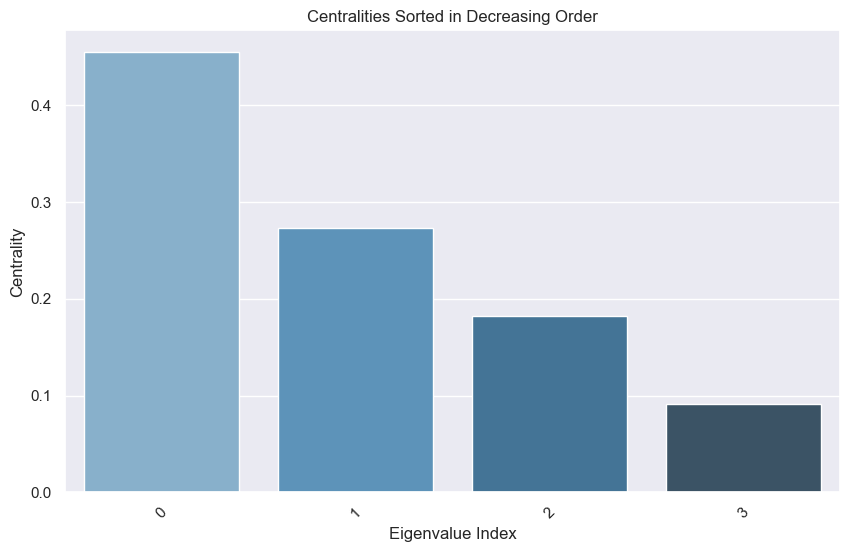

In [5]:
env = build_environment()
env.render(mode="centralities")

Ran for 21 steps: done=True, truncated=False
Ran for 21 steps: done=True, truncated=False


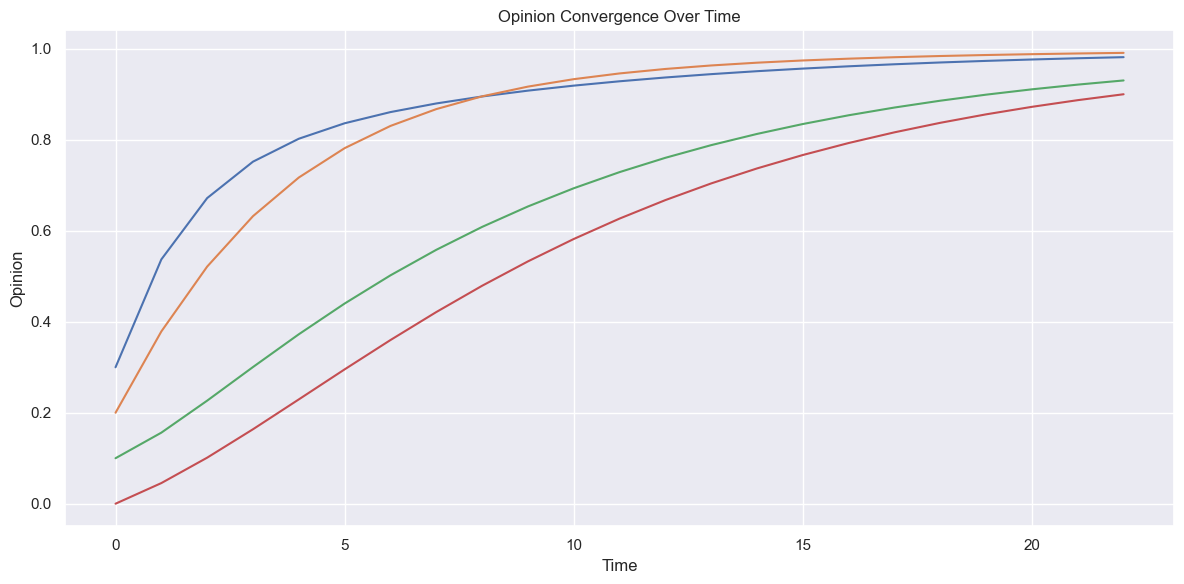

-4.337174365871242

In [6]:

num_steps = 100
nx = 8

# policy_broadcast = generate_full_control_policy(env, nx)
policy_broadcast = generate_control_from_vector(env, nx, [0.4, 0.2, 0.0, 0.0])

opinions_over_time, time_points, rewards = run_policy(env, policy_broadcast, nx=nx, step_duration=env.tau, max_steps=num_steps)
plot_opinions_over_time(opinions_over_time)

# sum(rewards)

gamma = 0.9

total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

In [7]:
sum(rewards)

-7.079874681949521

Centrality-based policy finished after 16 steps. Done=True, Truncated=False


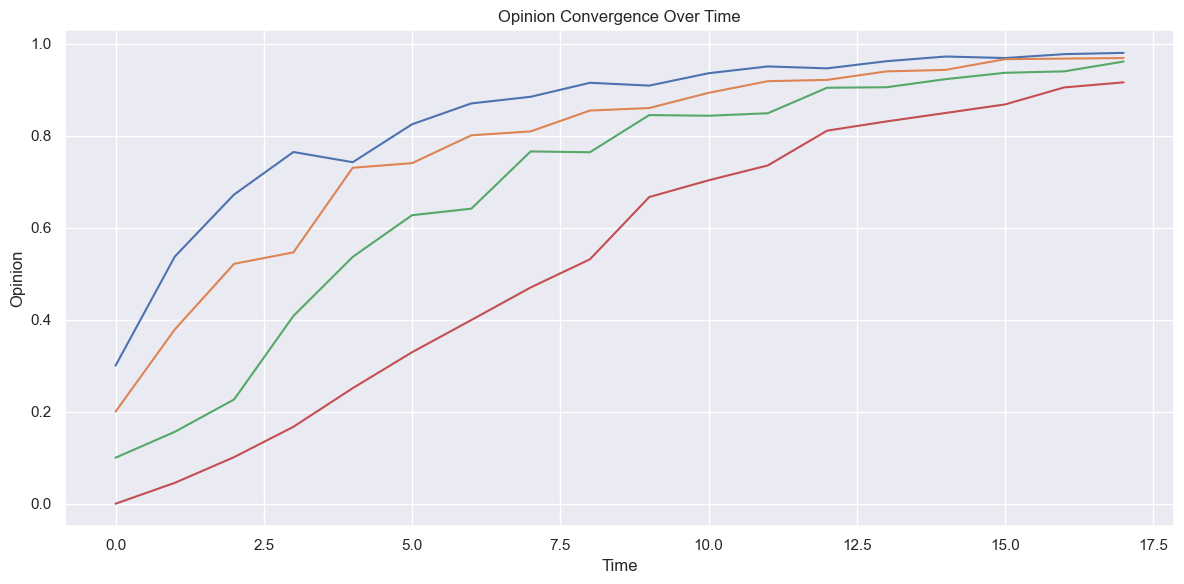

Total discounted reward: -3.9579599513278163


In [8]:
def centrality_based_continuous_control(env, available_budget):
    """
    Compute a control action distributing a continuous budget based on centrality * deviation heuristic.

    Args:
        env: The environment instance with `opinions`, `desired_opinion`, `centralities`, and `max_u` attributes.
        available_budget (float): Total control budget to distribute.

    Returns:
        control_action (np.array): Control action array (N,) where 0 <= control_action[i] <= max_u
        controlled_nodes (list): List of indices of nodes that received some control
    """
    N = env.num_agents
    deviations = np.abs(env.opinions - env.desired_opinion)  # (N,)
    influence_powers = env.centralities * deviations        # (N,)
    agent_order = np.argsort(influence_powers)[::-1]         # Sort descending by power

    control_action = np.zeros(N)
    remaining_budget = available_budget

    controlled_nodes = []

    for agent_idx in agent_order:
        if remaining_budget <= 0:
            break

        assign_amount = min(float(env.max_u[agent_idx]), remaining_budget)
        control_action[agent_idx] = assign_amount
        controlled_nodes.append(agent_idx)
        remaining_budget -= assign_amount

    return control_action, controlled_nodes

def run_centrality_policy(env, available_budget, step_duration, max_steps=1000):
    """
    Run the simulation using dynamic centrality-based continuous control.

    Args:
        env: The environment instance.
        available_budget (float): Total control budget per step.
        step_duration (float): Duration of each control application.
        max_steps (int): Maximum number of steps to run.

    Returns:
        opinions_over_time (np.ndarray): Array of opinions over time (steps, agents).
        time_points (np.ndarray): Array of time points.
        rewards_over_time (np.ndarray): Rewards collected at each step.
    """
    time_points = []
    rewards_over_time = []
    current_time = 0.0

    state, _ = env.reset()
    opinions_over_time = [state]

    for step in range(max_steps):
        # Compute dynamic action based on centralities and current state
        action, controlled_nodes = centrality_based_continuous_control(env, available_budget)

        next_state, reward, done, truncated, _ = env.step(action, step_duration)

        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)

        current_time += step_duration
        state = next_state

        if done or truncated:
            print(f"Centrality-based policy finished after {step} steps. Done={done}, Truncated={truncated}")
            break

    return np.array(opinions_over_time), np.array(time_points), np.array(rewards_over_time)


num_steps = 100
nx = 8
gamma = 0.9

env = build_environment()
available_budget = 0.6

opinions_over_time, time_points, rewards = run_centrality_policy(
    env,
    available_budget=available_budget,
    step_duration=env.tau,
    max_steps=num_steps
)

plot_opinions_over_time(opinions_over_time)

total_value = 0
for i, r in enumerate(rewards):
    total_value += (gamma ** i) * r

print(f"Total discounted reward: {total_value}")

In [9]:
env = build_environment()

# Adjusted parameters
step_duration = env.tau
max_total_budget = 0.6
action_levels = [0, 0.2, 0.4]

V = value_iteration(env, 
                    action_levels=action_levels,
                    nx=nx, 
                    gamma=gamma,  
                    step_duration=step_duration, 
                    max_total_budget=max_total_budget)
policy = extract_policy(
    env, 
    V, 
    action_levels=action_levels, 
    nx=nx, gamma=gamma, 
    step_duration=step_duration, 
    max_total_budget=max_total_budget
)

Converged in 42 iterations.


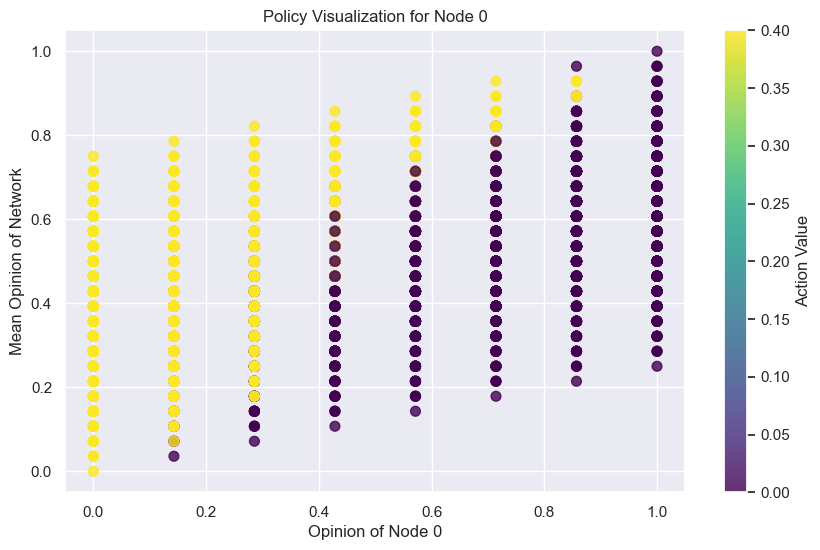

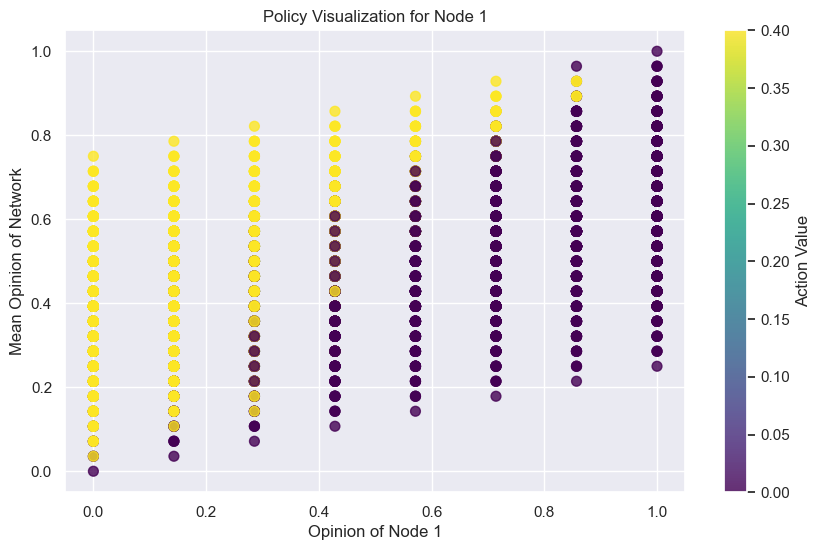

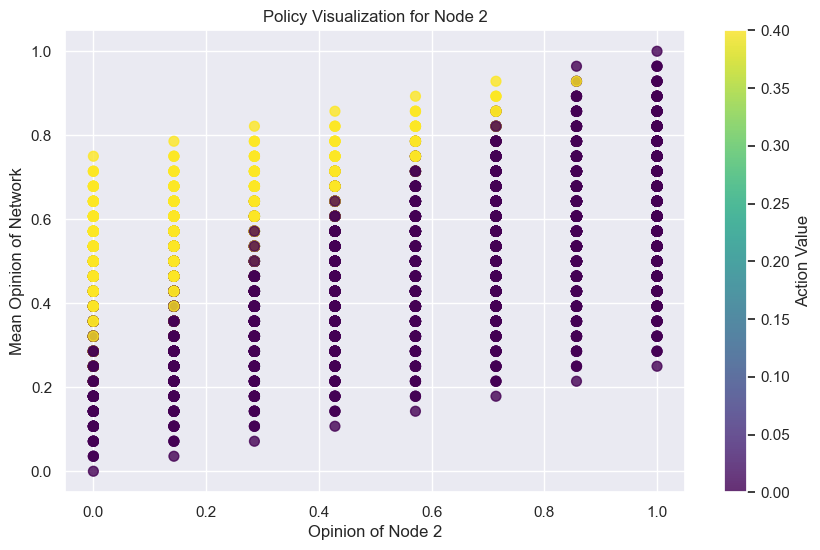

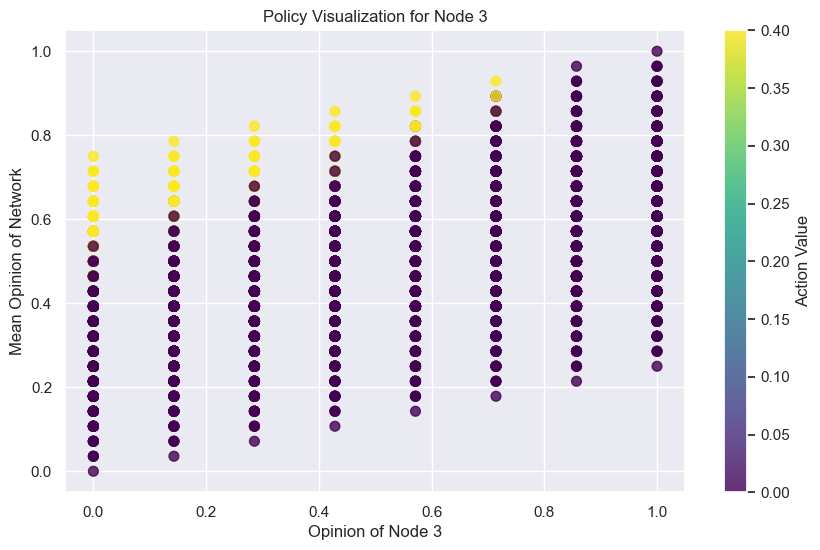

In [10]:
for node_index in range(env.num_agents):
    visualize_policy_from_env(policy, env, nx=nx, node_index=node_index)

Ran for 29 steps: done=False, truncated=False


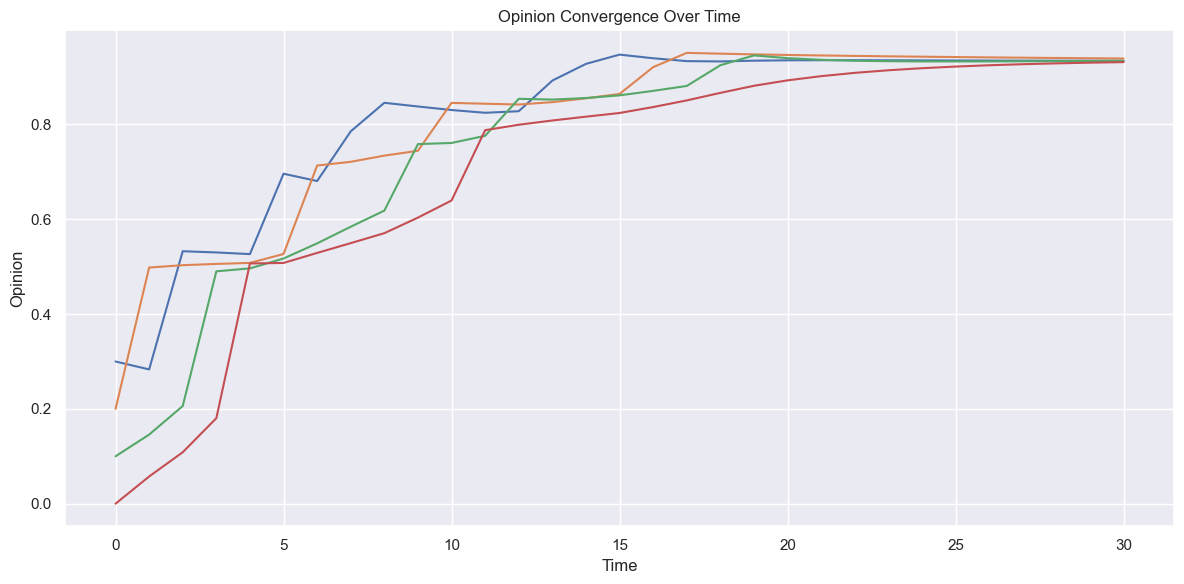

-4.405204087716186

In [11]:
env = build_environment()
num_steps = 30

opinions_over_time, time_points, rewards = run_policy(env, policy, nx=nx, step_duration=env.tau, max_steps=num_steps)
plot_opinions_over_time(opinions_over_time)
# sum(rewards)

total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

In [12]:
env.opinions

array([0.93442014, 0.93922591, 0.93417456, 0.93153004])

In [13]:
rewards

array([-0.89      , -0.79382913, -0.70238353, -0.61337506, -0.53055778,
       -0.47798946, -0.42191115, -0.37980306, -0.34775852, -0.30384849,
       -0.27083688, -0.23187164, -0.20908503, -0.18982797, -0.1761851 ,
       -0.16564905, -0.14792721, -0.13581954, -0.12149844, -0.07254873,
       -0.07124596, -0.07009857, -0.06910348, -0.06825124, -0.06752908,
       -0.06692289, -0.06641846, -0.06600217, -0.06566143, -0.06538485])

### DQN: 
Distributes budget beta_k (beta can be selected from discrete interval) across all nodes using W*
beta_k to be chosen constant

###  NAHS 
Distributes total budget B across M campaigns
At each campaign distributes the budget beta_k across all nodes using W_k
distribute the same beta_k as in the dqn experiment, and track